In [3]:
import torchaudio as ta
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
# from utils import *
import sys

def get_audio_paths(paths: list, file_extensions=['.wav', '.flac']):
    audio_paths = []
    if isinstance(paths, str):
        paths = [paths]
        
    for path in paths:
        for root, dirs, files in os.walk(path):
            audio_paths += [os.path.join(root, file) for file in files if os.path.splitext(file)[-1].lower() in file_extensions]
                        
    audio_paths.sort(key=lambda x: os.path.split(x)[-1])
    
    return audio_paths

def mask_random_subbands_per_frame(spec, num_subbands=32, mask_fraction=0.5):
    """
    Mask the random subbands in the spectrogram, independently for each frame.
    
    Args:
    spec (torch.Tensor): The input spectrogram with shape (B, 1, 1025, T).
    num_subbands (int): Total number of subbands to divide the frequency bins into.
    mask_fraction (float): Fraction of subbands to mask (e.g., 0.5 for 50%).

    Returns:
    torch.Tensor: The masked spectrogram.
    """

    # if spec.dim() == 3: # C x F x T
        # spec = spec.unsqueeze(0)
        
    C, F, T = spec.shape
    
    # The first subband includes indices 0-32 (33 frequency bins)
    subband0_size = 33
    
    # The remaining subbands each contain 32 frequency bins
    remaining_size = F - subband0_size
    subband_size = remaining_size // (num_subbands - 1)
    
    # First subband (indices 0-32)
    subband0 = spec[:, :subband0_size, :]
    
    # Remaining subbands (split into chunks of 32 frequency bins)
    subbands = [subband0]
    start_idx = subband0_size
    for _ in range(1, num_subbands):
        end_idx = min(start_idx + subband_size, F)
        subbands.append(spec[ :, start_idx:end_idx, :])
        start_idx = end_idx
    
    # Initialize the masked spectrogram as a list of tensors
    masked_spec = torch.zeros_like(spec)

    MASKINGVALUE = -1.112640558355952
    # For each frame, mask different subbands
    for t in range(T):
        # Select ratio of the subbands randomly for the current frame
        num_to_mask = int(mask_fraction * num_subbands)
        subband_indices = np.random.choice(num_subbands, num_to_mask, replace=False)
        
        # Apply masking to the selected subbands for the current frame
        masked_subbands = []
        for i, subband in enumerate(subbands):
            if i in subband_indices:
                # Mask this subband for the current frame
                masked_frame = torch.ones_like(subband[:, :, t:t+ 1]) * MASKINGVALUE
            else:
                # Keep the subband as is for the current frame
                masked_frame = subband[ :, :, t:t+1]
            
            masked_subbands.append(masked_frame)
        
        # Concatenate the masked subbands along the frequency dimension
        masked_spec[:, :, t:t+1] = torch.cat(masked_subbands, dim=1)
    
    return masked_spec


""" path_dir_wb = [path1, path2] """
class FeatureExtractorDataset(Dataset):
    def __init__(self, path_dir_wb, seg_len=3.6,):
        assert isinstance(path_dir_wb, list), "PATH must be a list"

        self.seg_len = seg_len
        
        paths_wav_wb = []
        for path in path_dir_wb:
            paths_wav_wb.extend(get_audio_paths(path, file_extensions='.wav'))

        print(f"GT {len(paths_wav_wb)} file numbers loaded!")

        self.filenames = paths_wav_wb
        print(f"{len(self.filenames)} files loaded")

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        path_wav_wb = self.filenames[idx]

        wav_wb, sr_wb = ta.load(path_wav_wb)

        if sr_wb != 48000:
            sys.exit(f"Error: Sample rate must be 48kHz!")

        wav_wb = wav_wb.view(1, -1)

        ## Select random starting point
        if self.seg_len > 0:
            duration = int(self.seg_len * sr_wb) # samples
            sig_len = wav_wb.shape[-1] # total signal length

            t_start = np.random.randint(low=0, high=max(1, sig_len - duration - 2), size=1)[0] # random starting
            t_end = t_start + duration

            wav_wb = wav_wb.repeat(1, t_end // sig_len + 1)[..., t_start:t_end] # repeat if signal is too short

        spec = self.get_log_spectrogram(wav_wb)
        spec = self.normalize_spec(spec)
        # print(spec.shape)

        masked_spec = mask_random_subbands_per_frame(spec)
        
        spec_e = self.extract_subband(spec, start=6, end=15)
        masked_spec_e = self.extract_subband(masked_spec, start=6, end=15)

        return wav_wb, spec, masked_spec, spec_e, masked_spec_e, get_filename(path_wav_wb)[0]

    @staticmethod
    def get_log_spectrogram(waveform):
        n_fft = 2048
        hop_length = 2048 
        win_length = 2048

        spectrogram = ta.transforms.Spectrogram(
            n_fft=n_fft, 
            hop_length=hop_length, 
            win_length=win_length, 
            power=2.0
        )(waveform)

        # return spectrogram[:, :]  
        
        log_spectrogram = ta.transforms.AmplitudeToDB()(spectrogram)
        return log_spectrogram[:, :]  

    def normalize_spec(self, spec):
        norm_mean = -42.61
        norm_std = 25.79
        spec = (spec - norm_mean) / (norm_std * 2)
        return spec

    def extract_subband(self, spec, start=6, end=15):
        """ Get spectrogram Inputs and extract range of subbands : [start:end+1] """
        
        C,F,T = spec.shape
        num_subband = 32
        freqbin_size = F // num_subband
        dc_line = spec[:,0,:].unsqueeze(1)

        f_start = 1 + freqbin_size * start
        f_end = 1 + freqbin_size * (end+1)

        extracted_spec = spec[:,f_start:f_end,:]
        if f_start == 1:
            extracted_spec = torch.cat((dc_line, extracted_spec),dim=1)

        print(f_start/1024 * 24000, f_end/1024 * 24000)

        return extracted_spec

         
# 2-D input spectrogram
def draw_spec(spectrogram, waveform, sample_rate, title="Spectrogram", 
                figsize=(10,4), vmin=-1.1, vmax=1.6, freq_range=None):
    n_fft = 2048

    # frequency axis
    freq_bins = np.fft.rfftfreq(n_fft, d=1/sample_rate)
    if freq_range:
        s,e = freq_range
        start = 24000 / 32 * s
        end = 24000 / 32 * (e+1)
    else:
        start = freq_bins.min()
        end = freq_bins.max()
    plt.figure(figsize=figsize)
    # imshow
    plt.imshow(spectrogram, aspect='auto', origin='lower', cmap='inferno',
                extent=[0, waveform.shape[-1] / sample_rate, start, end],
                vmin=vmin, vmax=vmax,
                )

    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.show()

def plot_hist(spec):
    spec_flat = spec.flatten().numpy()
    
    # Get min and max values
    min_val = spec_flat.min()
    max_val = spec_flat.max()
    
    print("Min value:", min_val)
    print("Max value:", max_val)
    
    # Plot hist
    plt.figure(figsize=(4, 4))
    plt.hist(spec_flat, bins=50, color='blue', alpha=0.7)
    
    # Set x-axis limits to the min and max values of the data
    plt.xlim(min_val, max_val)
    plt.title('Histogram of Spectrogram Values')
    plt.xlabel('Spectrogram Value (dB)')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()


In [4]:
def normalize_spec(spec):
    norm_mean = -42.61
    norm_std = 25.79
    spec = (spec - norm_mean) / (norm_std * 2)
    return spec

(-1 * 25.79 * 2) - 42.61

t = normalize_spec(-100)
print(t)


-1.112640558355952


GT 51947 file numbers loaded!
51947 files loaded
4523.4375 12023.4375
4523.4375 12023.4375
('78796_mono',)
torch.Size([1, 1, 1025, 94]) : SPEC Shape
torch.Size([1, 1, 1025, 94]) : SPECMASK Shape
Min value: -1.1126405
Max value: 1.5706246


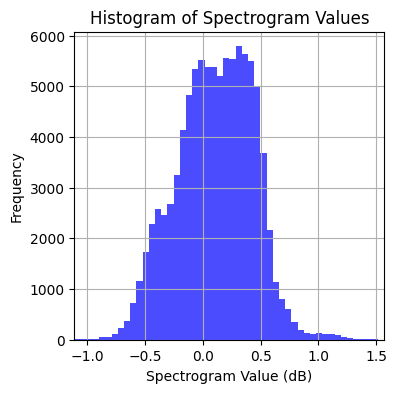

torch.Size([1025, 94])


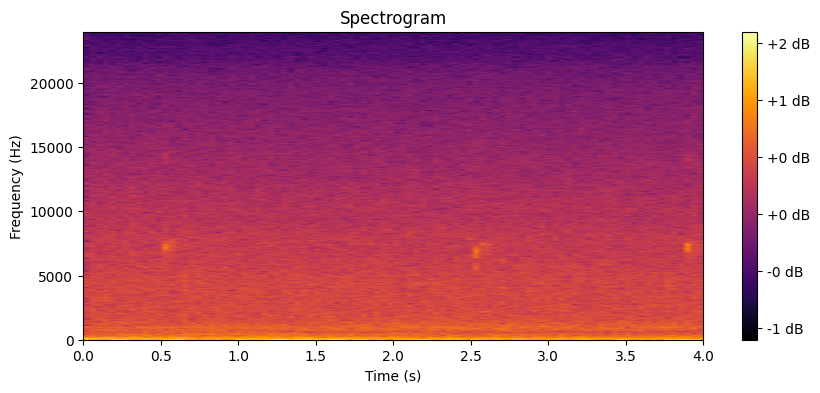

torch.Size([1025, 94]) SPECMASK


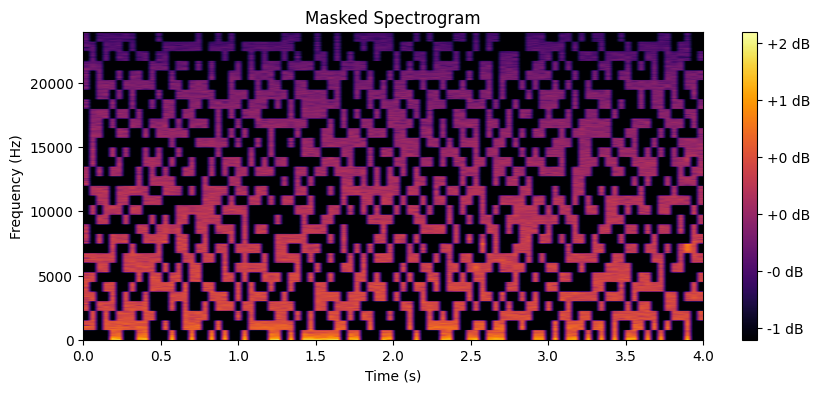

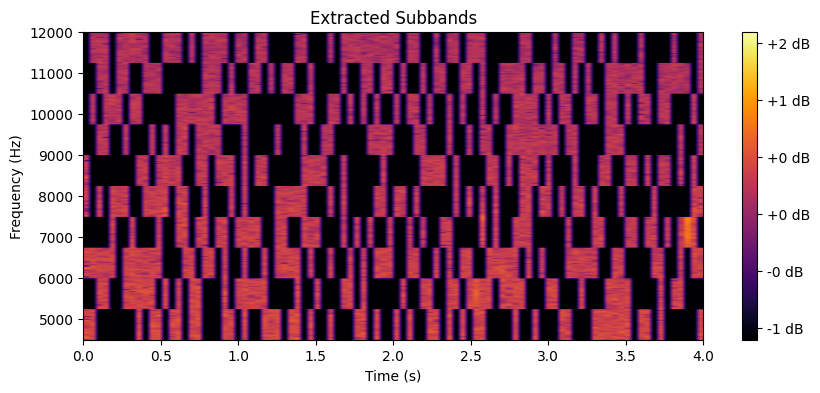

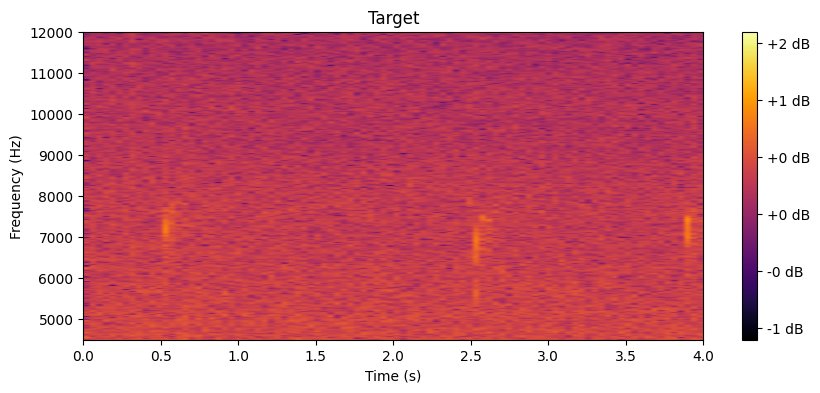

torch.Size([1, 192000])


torch.Size([320, 94])


In [5]:
from IPython.display import Audio, display


# Path to 48 kHz Audio Dataset
path_dir_wb = ["/mnt/hdd/Dataset/FSD50K_48kHz", "/mnt/hdd/Dataset/MUSDB18_HQ_mono_48kHz"]
dataset = FeatureExtractorDataset(path_dir_wb, seg_len=4)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

## Dataset
b = 0
for wb, spec, spec_mask, spec_e, spec_mask_e, name in dataloader:
    b += 1

    print(name)
    print(spec.shape,": SPEC Shape")
    print(spec_mask.shape,": SPECMASK Shape")
    plot_hist(spec)
    
    spec = spec[0,0,:,:]
    print(spec.shape)
    draw_spec(spec, wb, sample_rate=48000,)

    spec_mask = spec_mask[0,0,:,:]
    print(spec_mask.shape,"SPECMASK")
    draw_spec(spec_mask, wb, sample_rate=48000, title="Masked Spectrogram")

    spec_mask_e = spec_mask_e[0,0,:,:]
    draw_spec(spec_mask_e, wb, sample_rate=48000, freq_range=[6,15], title="Extracted Subbands")

    spec_e = spec_e[0,0,:,:]
    draw_spec(spec_e, wb, sample_rate=48000, freq_range=[6,15], title="Target")

    wb = wb[0,...]
    print(wb.shape)
    display(Audio(wb.squeeze().numpy(),rate=48000))
    if b == 1:
        break

print(spec_e.shape)





#### 288 x T

In [68]:
# from tqdm import tqdm
# all_spec = []
# dataset = FeatureExtractorDataset(path_dir_wb, seg_len=3, mode="train")
# dataset2 = SmallDataset(dataset, len(dataset)//4)
# dataloader = DataLoader(dataset2, batch_size=32, shuffle=True, num_workers=8, prefetch_factor=2)

# bar = tqdm(dataloader)

# for _, spec, name in bar:
#     spec = spec.view(-1, spec.shape[2], spec.shape[3])  # (B*C, F, T) 형태로 변환
#     all_spec.append(spec.flatten(start_dim=1))  # 배치의 모든 데이터를 플래튼하여 추가

# # concatenate using torch
# all_spec = torch.cat(all_spec, dim=0)

# global_mean = torch.mean(all_spec).item()
# global_std = torch.std(all_spec).item()


In [69]:
# print(global_mean,global_std)